In [1]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

SEED

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

PREPROCESSING

In [3]:
ROOT_DIR = "./img_cls_scenes_classification/scenes_classification"
train_dir = os.path.join(ROOT_DIR, "train")
test_dir = os.path.join(ROOT_DIR, "val")

classes = {
    label_idx : label for label_idx, label in enumerate(os.listdir(train_dir))
}

In [4]:
# Create a mapping of class names train and test directories
x_train = []
y_train = []
x_test = []
y_test = []

for dataset_path in [train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if dataset_path == train_dir:
                x_train.append(img_path)
                y_train.append(label_idx)
            else:
                x_test.append(img_path)
                y_test.append(label_idx)

In [5]:
# Split the training data into training and validation sets
seed = 0
val_size = 0.2
is_shuffle = True
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=val_size, random_state=seed, shuffle=is_shuffle
)

In [6]:
# Dataset class
class ScenesDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.img_paths = x
        self.labels = y
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)
        
        return img, self.labels[idx]
    
# Define the transformations
def transform_img(img, size=(224, 224)):
    img = img.resize(size)
    img = np.array(img)[..., :3]  # Ensure 3 channels
    img = img / 255.0
    normalized_img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # Convert to CxHxW
    return normalized_img

In [7]:
# Create datasets
train_dataset = ScenesDataset(x_train, y_train, transform=transform_img)
val_dataset = ScenesDataset(x_val, y_val, transform=transform_img)
test_dataset = ScenesDataset(x_test, y_test, transform=transform_img)

In [8]:
# Create dataloaders
train_batch_size = 32
val_batch_size = 16
test_batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

BUILDING MODEL DENSNET

Building Dense Block

In [9]:
class BottleNeckBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleNeckBlock, self).__init__()
        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        res = x.clone().detach()
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = torch.cat((x, res), dim=1)
        return x
    
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleNeckBlock(in_channels + i * growth_rate, growth_rate)) # core idea of dense block
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

Building DenseNet

In [10]:
class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate, num_classes):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(2 * growth_rate)
        self.maxpooling1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.dense_blocks = nn.ModuleList()
        in_channels = 2 * growth_rate
        for i, num_layers in enumerate(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
            in_channels += num_layers * growth_rate # this is the output channels of the dense block and stack channel of the block above
            if i != len(num_blocks) - 1: # Check if not the last block
                # Transition layer
                # Reduce the number of channels by half and downsample
                out_channels = in_channels // 2
                self.dense_blocks.append(nn.Sequential(
                    nn.BatchNorm2d(in_channels),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                ))
                in_channels = out_channels
        self.batch_norm2 = nn.BatchNorm2d(in_channels)
        self.avgpool2 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.maxpooling1(x)

        for block in self.dense_blocks:
            x = block(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.avgpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

UTILS

In [11]:
# Evaluation function
def evaluate(model, valid_dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        valid_loader_tqdm = tqdm(valid_dataloader, desc="Validating", leave=False)
        for inputs, labels in valid_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss = sum(losses) / len(losses)
    accuracy = correct / total * 100
    return loss, accuracy

# Training function
def train(
        model, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs=10, device="cuda"
):
    train_losses = []
    valid_losses = []
    best_model_path = "./model/best_model_scene_classification.pth"

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        batch_train_losses = []
        model.train()

        train_loader_tqdm = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs} Training", leave=False)
        for idx, (inputs, labels) in enumerate(train_loader_tqdm):
            inputs,labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        # Validation
        valid_loss, valid_accuracy = evaluate(model, valid_dataloader, criterion, device)
        valid_losses.append(valid_loss)
        print(
            f"Train Loss: {train_loss:.4f}, "
            f"Valid Loss: {valid_loss:.4f}, "
            f"Valid Accuracy: {valid_accuracy:.2f}%"
        )
        # Save the model
        best_validation_loss = 100
        if valid_loss < best_validation_loss:
            best_validation_loss = valid_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"INFO: New best model saved at epoch {epoch + 1} with validation loss: {best_validation_loss:.4f}")

    print("Finished Training.")
    print(f"Best model saved at '{best_model_path}' with validation loss: {best_validation_loss:.4f}")
    return train_losses, valid_losses
            

In [12]:
num_classes = len(list(classes.keys()))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = DenseNet(num_blocks=[6, 12, 24, 16], growth_rate=32, num_classes=num_classes).to(DEVICE)

LEARNING_RATE = 0.001
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

Epochs:  20%|██        | 1/5 [01:34<06:17, 94.37s/it]

Train Loss: 1.6753, Valid Loss: 1.5646, Valid Accuracy: 44.18%
INFO: New best model saved at epoch 1 with validation loss: 1.5646


Epochs:  40%|████      | 2/5 [03:05<04:37, 92.53s/it]

Train Loss: 1.5216, Valid Loss: 1.4524, Valid Accuracy: 51.94%
INFO: New best model saved at epoch 2 with validation loss: 1.4524


Epochs:  60%|██████    | 3/5 [04:35<03:02, 91.14s/it]

Train Loss: 1.4374, Valid Loss: 1.3806, Valid Accuracy: 52.80%
INFO: New best model saved at epoch 3 with validation loss: 1.3806


Epochs:  80%|████████  | 4/5 [06:07<01:31, 91.78s/it]

Train Loss: 1.3826, Valid Loss: 1.3308, Valid Accuracy: 54.40%
INFO: New best model saved at epoch 4 with validation loss: 1.3308


Epochs: 100%|██████████| 5/5 [07:41<00:00, 92.23s/it]


Train Loss: 1.3359, Valid Loss: 1.2935, Valid Accuracy: 55.97%
INFO: New best model saved at epoch 5 with validation loss: 1.2935
Finished Training.
Best model saved at './model/best_model_scene_classification.pth' with validation loss: 1.2935


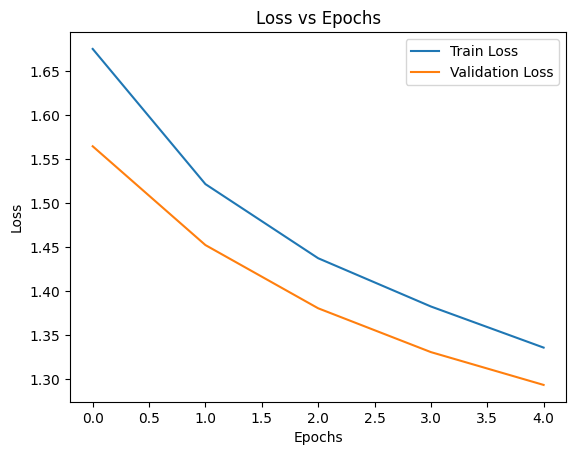

In [13]:
train_losses, valid_losses = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=epochs,
    device=DEVICE
)

# Plotting the loss
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
print("Evaluation on test dataset")
print("Test accuracy", test_acc)

Evaluation on test dataset
Test accuracy 53.300000000000004
